## Import libraries

In [1]:
import sys
sys.path.append('../')

In [2]:
from src.data.get_data import get_data
from src.data.get_bacen import consulta_bc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime as dt
import warnings
warnings.simplefilter("ignore")


In [3]:
from src.features.build_features import get_returns, get_duration, get_janelas_rolantes
from src.visualization.visualize import grafico_janelas_rolantes
from src.visualization.visualize import grafico_janelas_rolantes_vol

## GET DATA

In [6]:
path = r"../data/raw/ANBIMA/IMAB-HISTORICO.xls"
pasta = r"../reports/figures/"

In [7]:
df = get_data(path)

## EDA

In [8]:
dataset_returns = get_returns(df)
dataset_duration = get_duration(df)
dataset_janelas_rolantes_12M = get_janelas_rolantes(df)[0]
dataset_janelas_rolantes_24M = get_janelas_rolantes(df)[1]


#### RETORNO MEDIO DO IMAB JANELAS ROLANTES DE 12M

In [9]:
media = round(dataset_janelas_rolantes_12M.describe(),2)

### Acompanhamento Janelas Rolantes

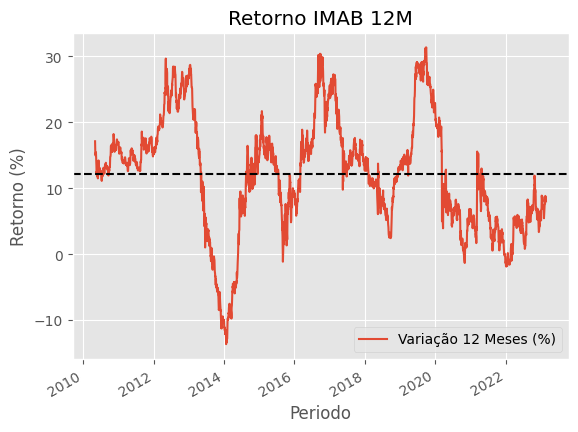

In [10]:
fig1 = grafico_janelas_rolantes(dataset_janelas_rolantes_12M
                                ,'Data de Referência'
                                ,'Variação 12 Meses (%)'
                                ,"IMAB"
                                ,"12M")

fig1.savefig(pasta+"IMAB_12M.png")


### VOLATILITY ANALISYS

In [11]:
rolling_vol = (dataset_returns.rolling(window=252).std())*np.sqrt(252)
rolling_vol_tri = (dataset_returns.rolling(window=66).std())*np.sqrt(252) #Rolling vol 3M anualizada

In [12]:
#Copia dataset janela rolante return 12M
merge_vol_return = dataset_janelas_rolantes_12M.copy()

#Inclui a volatilidade anual
merge_vol_return["Vol 12 Meses"] = rolling_vol

#Inclui volatilidade 3M anualizada
merge_vol_return["Vol 3 Meses"] = rolling_vol_tri
merge_vol_return.dropna(inplace=True)

In [19]:
vol_media = merge_vol_return.describe().round(2)

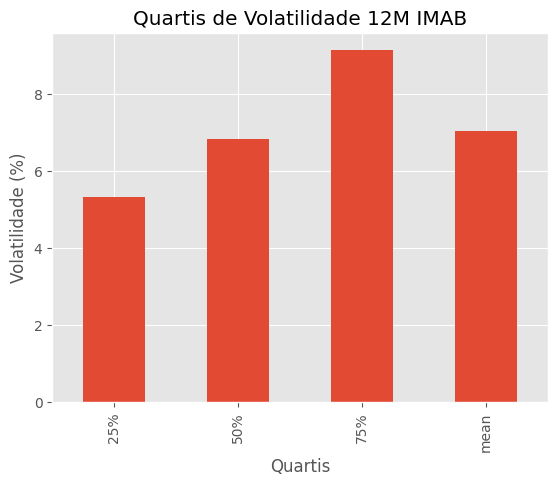

In [45]:
fig3,ax = plt.subplots()
vol_media.iloc[[4,5,6,1],1].plot(
  kind="bar",
  xlabel="Quartis",
  ylabel="Volatilidade (%)",
  title="Quartis de Volatilidade 12M IMAB",
  ax=ax
);
fig3.savefig(pasta+"quartis_vol_IMAB.png")


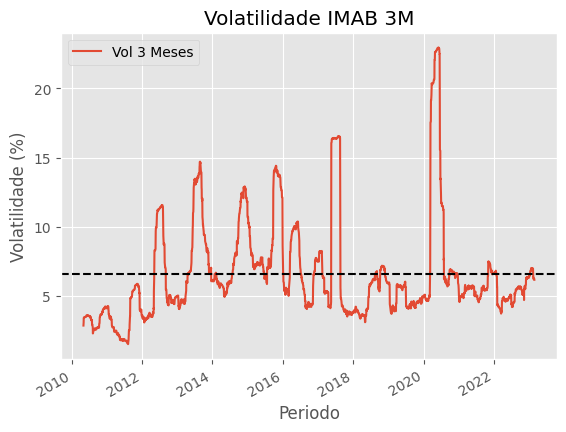

In [23]:
fig2 = grafico_janelas_rolantes_vol(merge_vol_return
                                ,"Data de Referência"
                                ,"Vol 3 Meses"
                                ,"IMAB"
                                ,"3M")
fig2.savefig(pasta+"IMAB_3M_vol.png")

### Sharpe Ratio Analysis

In [69]:
#get the cdi dataframe
df_cdi = consulta_bc(12)
df_cdi.rolling(window=252).sum().dropna(inplace=True)

#Define new Feature Column df_cdi
df_cdi["data"] = df_cdi.index

#Drop index df_cdi 
df_cdi.reset_index(drop=True,inplace=True)
#Returno Anual em janelas rolantes
df_cdi["Variação 12 Meses (%)"] = df_cdi["valor"].rolling(window=252).sum()

In [81]:
#Define new columns to merge_data_new_df
merge_vol_return.columns = ["data",'Variação 12 Meses (%)','Vol 12 Meses','Vol 3 Meses']

#merge data
merge_imab_di = merge_vol_return.merge(df_cdi,on="data",how='inner',suffixes=["_IMAB","_CDI"])

#Drop specific column
merge_imab_di.drop(columns='valor',inplace=True)


In [93]:
sharpe_ratio = (merge_imab_di["Variação 12 Meses (%)_IMAB"]-merge_imab_di["Variação 12 Meses (%)_CDI"])/merge_imab_di["Vol 12 Meses"]

df_sr = pd.DataFrame({"Sharpe Ratio":sharpe_ratio
                      ,"data":merge_imab_di["data"]}).round(2)

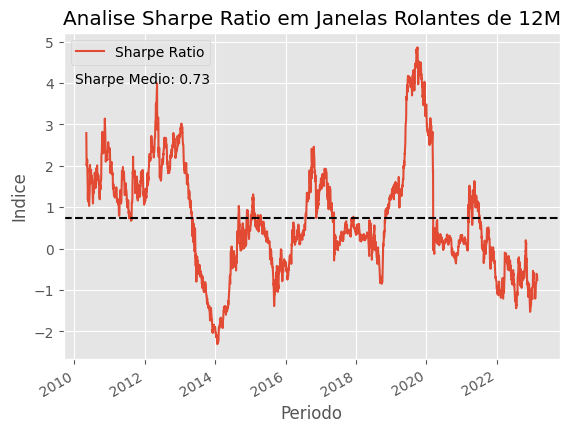

In [108]:
fig4,ax = plt.subplots()

df_sr.plot(
          kind="line",
          x = "data",
          y = "Sharpe Ratio",
          xlabel = "Periodo",
          ylabel = "Indice",
          title="Analise Sharpe Ratio em Janelas Rolantes de 12M",
          ax=ax

)

ax.axhline(y=df_sr["Sharpe Ratio"].mean(),color="black",label="Average",linestyle="--");
ax.text('01-05-2010',4,f'Sharpe Medio: {round(df_sr["Sharpe Ratio"].mean(),2)}');
fig4.savefig(pasta+"sharpe_ratio_IMAB.png")

In [92]:
df_sr.head()

,Sharpe Ratio,data
0,2.7883,2010-05-04
1,2.5979,2010-05-05
2,2.3833,2010-05-06
3,2.0091,2010-05-07
4,2.0481,2010-05-10
